In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev, InterpolatedUnivariateSpline
import datetime as dt
import matplotlib.pyplot as plt
import json
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [537]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id].reset_index(drop=True)


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T


def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    if 't' not in data.columns:
        data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                   np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

def stretch_simulated_feats(data, stretch,true_feats = 'position',
                           suffix="_stretch"):
    '''
    stretch time scale for simulation to better match true data,
    for a single sattelite;
    use predetermined stretch coefficient (depends on the satellite)
    
    '''
    if true_feats == 'position':
        true_feats_list = ['x','y','z']
    elif true_feats == 'velocity':
        true_feats_list = ['Vx','Vy','Vz']
    elif true_feats == 'all':
        true_feats_list = ['x','y','z','Vx','Vy','Vz']
    else:
        true_feats_list = true_feats
    
    for feature in true_feats_list:
        spl = splrep(stretch*data['t'],data[feature+'_sim'])
        test_stretch = splev(data['t'], spl) #np array
        data[feature+suffix] = test_stretch
    
    return data

def amp_sim_feats(data, amp_stretch,true_feats = ['Vx','Vy','Vz'],
                           suffix="_stretch_amp"):
    '''
    vary amplitude for simulation to better match true data,
    for a single sattelite;
    use predetermined amp_stretch coefficient (depends on the satellite)
    
    '''
    if true_feats == 'position':
        true_feats_list = ['x','y','z']
    elif true_feats == 'velocity':
        true_feats_list = ['Vx','Vy','Vz']
    elif true_feats == 'all':
        true_feats_list = ['x','y','z','Vx','Vy','Vz']
    else:
        true_feats_list = true_feats
        
    for feature in true_feats_list:
        data[feature+suffix] = amp_stretch*data[feature+'_stretch']
    
    return data

In [6]:
#!jupyter nbconvert --to script utils_edit_mb.ipynb

In [5]:
s_data = pd.read_csv('./data/train.csv', index_col= 'id')

In [7]:
s_data_test = pd.read_csv('./data/test.csv', index_col= 'id')

In [20]:
s_track_1 = list(s_data_test['sat_id'].unique())
s_track_2 = [k for k in range(600) if k not in s_track_1]

In [21]:
data = get_satellite_data(s_data, 0)
#data.tail()

In [22]:
data_rtjf = remove_time_jumps_fast(data)
#data_rtjf.tail()

In [12]:
#run for all satellites and print sat id if error occurs
from tqdm import tqdm
for i in tqdm(range(600)):
    try:
        remove_time_jumps_fast(get_satellite_data(s_data, i))
    except:
        print(i)

100%|██████████| 600/600 [00:07<00:00, 83.42it/s] 


In [435]:
smape(data['Vz'],data['Vz_sim'])

0.5266913919185304

In [436]:
smape(data['Vz'],stretch_simulated_feats(data, stretch_dict[id],true_feats = ['Vz',])['Vz_stretch'])

0.4476157302430831

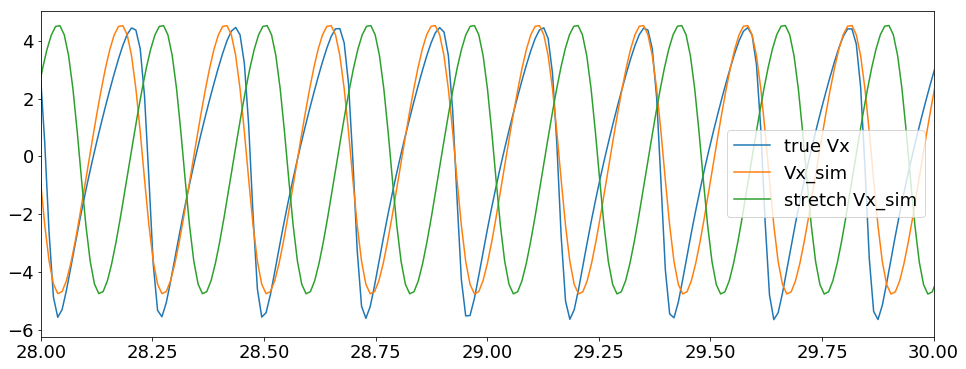

In [427]:
id = 587
data = remove_time_jumps_fast(get_satellite_data(s_data, id))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx');
plt.plot(data['t'],data['Vx_sim'], label = 'Vx_sim');
plt.plot(stretch_dict[id]*data['t'],data['Vx_sim'], label = 'stretch Vx_sim');

#plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([28,30])
plt.legend();

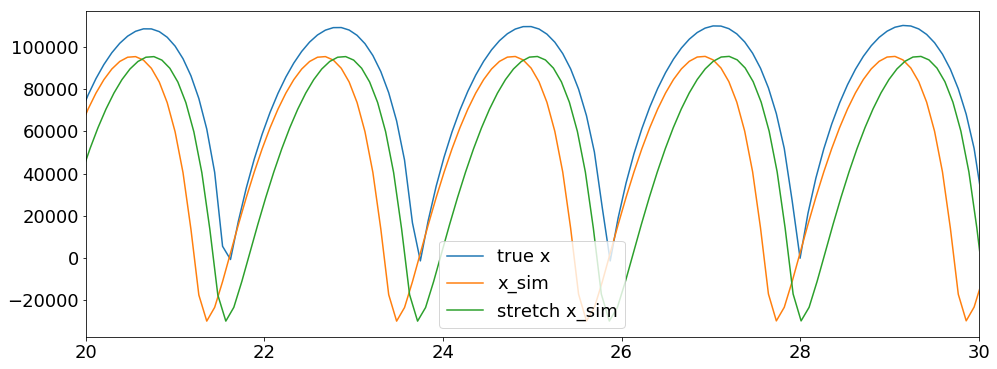

In [402]:
id = 572
data = remove_time_jumps_fast(get_satellite_data(s_data, id))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['x'], label = 'true x');
plt.plot(data['t'],data['x_sim'], label = 'x_sim');
plt.plot(stretch_dict[id]*data['t'],data['x_sim'], label = 'stretch x_sim');

#plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend();

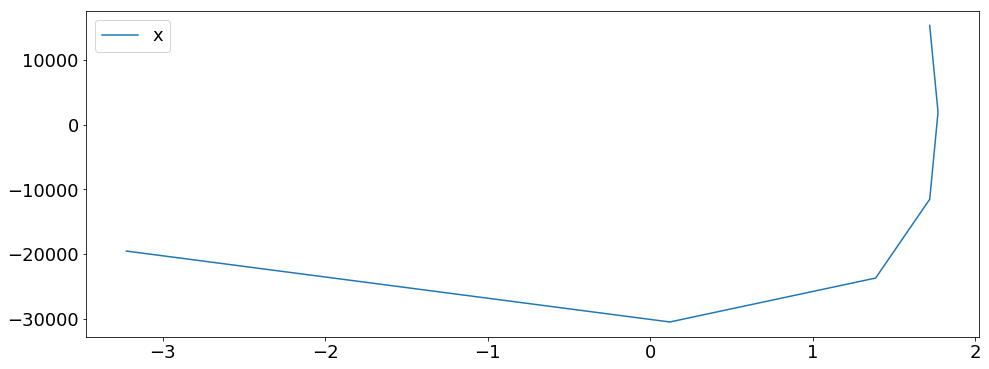

In [439]:
id = 572
data = remove_time_jumps_fast(get_satellite_data(s_data, id))
plt.figure(figsize=(16, 6))
data_t = data[data['t'] <= .5]
plt.plot(data_t['Vx'],data_t['x'])#, label = 'true x');
#plt.plot(data['t'],data['x_sim'], label = 'x_sim');
#plt.plot(stretch_dict[id]*data['t'],data['x_sim'], label = 'stretch x_sim');

#plt.xlim([0,10])
#plt.xlim([10,20])
#plt.xlim([20,30])
plt.legend();

## Explore time scale stretch for simulations

The same stretch coefficient appears to work well for all dimensions

In [11]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

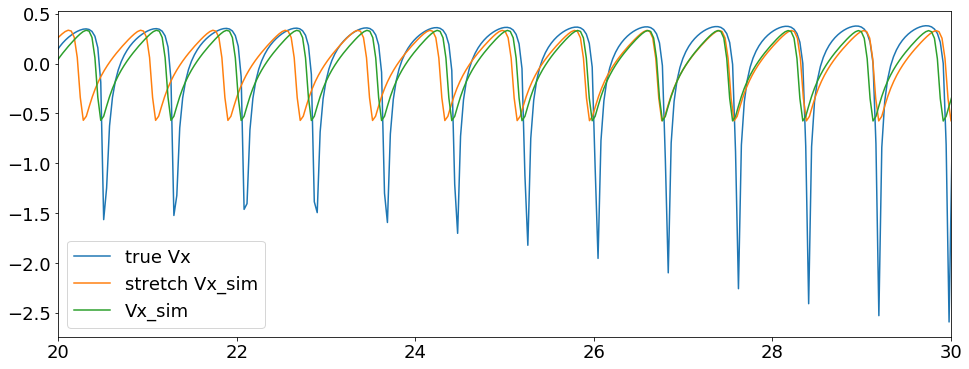

In [12]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 530))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vz'], label = 'true Vx');
plt.plot(1.03*data['t'],data['Vz_sim'], label = 'stretch Vx_sim');
plt.plot(data['t'],data['Vz_sim'], label = 'Vx_sim');

plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend();

In [13]:
smape(data[true_feats].to_numpy(),data[sim_feats].to_numpy())

0.2805457851994837

In [14]:
data = stretch_simulated_feats(data,1.05)
smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())

0.6869481884255387

## Horizontal stretch for velocity

In [500]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [501]:
stretch_dict = {}
for sat in tqdm(s_data['sat_id'].unique()):
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        data = stretch_simulated_feats(data,i,true_feats='velocity')
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]








  0%|          | 0/600 [00:00<?, ?it/s]






  0%|          | 1/600 [00:00<01:17,  7.69it/s]






  0%|          | 2/600 [00:00<01:16,  7.84it/s]






  1%|          | 4/600 [00:00<01:04,  9.30it/s]






  1%|          | 6/600 [00:00<01:05,  9.06it/s]






  1%|▏         | 8/600 [00:00<00:56, 10.43it/s]






  2%|▏         | 10/600 [00:00<00:51, 11.40it/s]






  2%|▏         | 12/600 [00:01<00:53, 11.03it/s]






  2%|▏         | 14/600 [00:01<00:51, 11.33it/s]






  3%|▎         | 16/600 [00:01<00:49, 11.92it/s]






  3%|▎         | 18/600 [00:01<00:49, 11.64it/s]






  3%|▎         | 20/600 [00:01<00:48, 11.87it/s]






  4%|▎         | 22/600 [00:01<00:45, 12.63it/s]






  4%|▍         | 24/600 [00:02<00:45, 12.55it/s]






  4%|▍         | 26/600 [00:02<00:43, 13.05it/s]






  5%|▍         | 28/600 [00:02<00:41, 13.67it/s]






  5%|▌         | 31/600 [00:02<00:36, 15.70it/s]






  6%|▌         | 34/600 [00:02<00:33, 17.04it/s]






  6%|▌         | 

 46%|████▌     | 277/600 [00:14<00:16, 19.48it/s]






 46%|████▋     | 279/600 [00:15<00:16, 19.57it/s]






 47%|████▋     | 281/600 [00:15<00:17, 18.18it/s]






 47%|████▋     | 283/600 [00:15<00:17, 18.01it/s]






 48%|████▊     | 285/600 [00:15<00:18, 16.94it/s]






 48%|████▊     | 288/600 [00:15<00:17, 17.93it/s]






 48%|████▊     | 291/600 [00:15<00:16, 19.17it/s]






 49%|████▉     | 293/600 [00:15<00:15, 19.26it/s]






 49%|████▉     | 296/600 [00:15<00:16, 18.87it/s]






 50%|████▉     | 298/600 [00:16<00:16, 17.92it/s]






 50%|█████     | 300/600 [00:16<00:16, 18.10it/s]






 50%|█████     | 302/600 [00:16<00:16, 18.41it/s]






 51%|█████     | 305/600 [00:16<00:15, 19.33it/s]






 51%|█████     | 307/600 [00:16<00:15, 19.39it/s]






 52%|█████▏    | 309/600 [00:16<00:16, 17.80it/s]






 52%|█████▏    | 311/600 [00:16<00:15, 18.40it/s]






 52%|█████▏    | 313/600 [00:16<00:17, 16.84it/s]






 53%|█████▎    | 316/600 [00:17<00:15, 18.16it/s

 88%|████████▊ | 530/600 [00:28<00:04, 15.96it/s]






 89%|████████▊ | 532/600 [00:28<00:04, 16.14it/s]






 89%|████████▉ | 534/600 [00:28<00:03, 17.10it/s]






 89%|████████▉ | 536/600 [00:29<00:03, 16.23it/s]






 90%|████████▉ | 539/600 [00:29<00:03, 17.39it/s]






 90%|█████████ | 542/600 [00:29<00:03, 18.06it/s]






 91%|█████████ | 545/600 [00:29<00:02, 19.09it/s]






 91%|█████████ | 547/600 [00:29<00:02, 19.06it/s]






 92%|█████████▏| 549/600 [00:29<00:02, 19.33it/s]






 92%|█████████▏| 551/600 [00:29<00:02, 18.48it/s]






 92%|█████████▏| 554/600 [00:30<00:02, 18.39it/s]






 93%|█████████▎| 556/600 [00:30<00:02, 17.56it/s]






 93%|█████████▎| 558/600 [00:30<00:02, 17.89it/s]






 93%|█████████▎| 560/600 [00:30<00:02, 17.88it/s]






 94%|█████████▍| 563/600 [00:30<00:01, 18.93it/s]






 94%|█████████▍| 566/600 [00:30<00:01, 19.54it/s]






 95%|█████████▍| 569/600 [00:30<00:01, 20.55it/s]






 95%|█████████▌| 572/600 [00:30<00:01, 20.70it/s

In [502]:
extreme_stretch = {k for k,v in stretch_dict.items() if (v <= 0.98 or v >= 1.02)}

In [503]:
for sat in extreme_stretch:
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.94,1.06,0.005):
        data = stretch_simulated_feats(data,i,true_feats = 'velocity')
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

In [504]:
for sat in extreme_stretch:
    print(sat,stretch_dict[sat])

35 1.02
260 1.02
515 1.0550000000000002
391 1.04
140 1.02
556 0.97
277 0.975
26 0.98
252 0.95


In [505]:
stretch_dict = {int(k):v for k,v in stretch_dict.items()}

#save stretch_dict
import json
with open('stretch_dict.txt', 'w') as file:
    json.dump(stretch_dict, file)

with open('stretch_dict.txt', 'r') as file:
    stretch_dict = json.load(file)


## Horizontal stretch for position

In [506]:
true_feats = ['x','y','z']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [507]:
stretch_dict_pos = {}
for sat in tqdm(s_data['sat_id'].unique()):
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.98,1.02,0.005):
        data = stretch_simulated_feats(data,i,true_feats = 'position')
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_pos[sat] = best[0]








  0%|          | 0/600 [00:00<?, ?it/s]






  0%|          | 1/600 [00:00<01:05,  9.09it/s]






  0%|          | 2/600 [00:00<01:04,  9.22it/s]






  1%|          | 4/600 [00:00<00:57, 10.45it/s]






  1%|          | 5/600 [00:00<00:58, 10.16it/s]






  1%|          | 6/600 [00:00<00:59, 10.02it/s]






  1%|▏         | 8/600 [00:00<00:52, 11.27it/s]






  2%|▏         | 10/600 [00:00<00:47, 12.39it/s]






  2%|▏         | 12/600 [00:00<00:45, 12.83it/s]






  2%|▏         | 14/600 [00:01<00:46, 12.65it/s]






  3%|▎         | 16/600 [00:01<00:45, 12.72it/s]






  3%|▎         | 18/600 [00:01<00:43, 13.23it/s]






  3%|▎         | 20/600 [00:01<00:44, 13.00it/s]






  4%|▎         | 22/600 [00:01<00:44, 12.98it/s]






  4%|▍         | 24/600 [00:01<00:42, 13.40it/s]






  4%|▍         | 26/600 [00:02<00:59,  9.57it/s]






  5%|▍         | 28/600 [00:02<00:52, 10.88it/s]






  5%|▌         | 30/600 [00:02<00:46, 12.28it/s]






  5%|▌         | 3

 42%|████▏     | 249/600 [00:14<00:20, 16.91it/s]






 42%|████▏     | 252/600 [00:14<00:19, 18.09it/s]






 42%|████▏     | 254/600 [00:14<00:19, 17.69it/s]






 43%|████▎     | 256/600 [00:15<00:19, 18.10it/s]






 43%|████▎     | 258/600 [00:15<00:19, 17.56it/s]






 43%|████▎     | 260/600 [00:15<00:19, 17.15it/s]






 44%|████▎     | 262/600 [00:15<00:19, 17.56it/s]






 44%|████▍     | 264/600 [00:15<00:19, 17.54it/s]






 44%|████▍     | 267/600 [00:15<00:17, 18.70it/s]






 45%|████▌     | 270/600 [00:15<00:16, 20.19it/s]






 46%|████▌     | 273/600 [00:15<00:18, 18.11it/s]






 46%|████▌     | 275/600 [00:16<00:20, 15.72it/s]






 46%|████▌     | 277/600 [00:16<00:20, 15.60it/s]






 46%|████▋     | 279/600 [00:16<00:20, 15.45it/s]






 47%|████▋     | 281/600 [00:16<00:20, 15.69it/s]






 47%|████▋     | 283/600 [00:16<00:19, 16.06it/s]






 48%|████▊     | 285/600 [00:16<00:19, 15.92it/s]






 48%|████▊     | 288/600 [00:16<00:17, 17.37it/s

 83%|████████▎ | 499/600 [00:28<00:05, 18.11it/s]






 84%|████████▎ | 501/600 [00:28<00:05, 16.97it/s]






 84%|████████▍ | 503/600 [00:28<00:05, 16.95it/s]






 84%|████████▍ | 505/600 [00:28<00:05, 16.50it/s]






 84%|████████▍ | 507/600 [00:29<00:05, 16.90it/s]






 85%|████████▍ | 509/600 [00:29<00:05, 17.17it/s]






 85%|████████▌ | 511/600 [00:29<00:05, 17.05it/s]






 86%|████████▌ | 513/600 [00:29<00:05, 16.98it/s]






 86%|████████▌ | 515/600 [00:29<00:04, 17.56it/s]






 86%|████████▋ | 518/600 [00:29<00:04, 19.16it/s]






 87%|████████▋ | 520/600 [00:29<00:04, 19.21it/s]






 87%|████████▋ | 522/600 [00:29<00:04, 19.20it/s]






 87%|████████▋ | 524/600 [00:29<00:04, 18.46it/s]






 88%|████████▊ | 526/600 [00:30<00:03, 18.67it/s]






 88%|████████▊ | 528/600 [00:30<00:06, 11.90it/s]






 88%|████████▊ | 530/600 [00:30<00:05, 12.79it/s]






 89%|████████▊ | 532/600 [00:30<00:04, 13.65it/s]






 89%|████████▉ | 535/600 [00:30<00:04, 15.19it/s

In [508]:
extreme_stretch_pos = {k for k,v in stretch_dict_pos.items() if (v <= 0.98 or v >= 1.02)}

In [509]:
for sat in extreme_stretch_pos:
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.9,1.1,0.005):
        data = stretch_simulated_feats(data,i,true_feats = 'position')
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict_pos[sat] = best[0]

In [510]:
for sat in extreme_stretch_pos:
    print(sat,stretch_dict_pos[sat])

515 1.08
260 1.0250000000000001
391 1.0450000000000002
556 0.9600000000000001
277 0.9650000000000001
438 0.9800000000000001
252 0.935


In [511]:
stretch_dict_pos = {int(k):v for k,v in stretch_dict_pos.items()}

#save stretch_dict
import json
with open('stretch_dict_pos.txt', 'w') as file:
    json.dump(stretch_dict_pos, file)

with open('stretch_dict_pos.txt', 'r') as file:
    stretch_dict_pos = json.load(file)

In [517]:
x = stretch_dict
y = stretch_dict_pos
shared_items = {k: x[k] for k in x if k in y and x[k] == y[k]}
print(len(shared_items)) #how many stretch coeffs in common for position and velocity

578


## Amplitude stretch: velocities 

In [524]:
true_feats = ['Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [525]:
# satellite 391 needs amplitude stretched
with open('stretch_dict.txt', 'r') as file:
    stretch_dict = json.load(file) #keys as strings
stretch_dict = {int(k) : v for k,v in stretch_dict.items()}
stretch_dict[391]

1.04

In [527]:
amp_dict = {dim: {} for dim in ['x','y','z']}
for dim in ['x','y','z']:
    for sat in range(600):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            data = get_satellite_data(s_data,sat)
            data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
            data = stretch_simulated_feats(data,stretch_dict[sat],true_feats = 'velocity')
            data = amp_sim_feats(data,i)
            metric = smape(data['V{}'.format(dim)].to_numpy(),data['V{}_stretch_amp'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict[dim][sat] = best[0]

In [528]:
extreme_amp = {}
for dim in ['x','y','z']:
    extreme_amp[dim] = [k for k,v in amp_dict[dim].items() if (v <= 0.9 or v >= 1.1)]
#extreme_amp

In [529]:
for dim in ['x','y','z']:
    for sat in extreme_amp[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.05):
            data = get_satellite_data(s_data,sat)
            data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
            data = stretch_simulated_feats(data,stretch_dict[sat],true_feats = 'velocity')
            data = amp_sim_feats(data,i)
            metric = smape(data['V{}'.format(dim)].to_numpy(),data['V{}_stretch_amp'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict[dim][sat] = best[0]

In [530]:
extreme_amp2 = {}
for dim in ['x','y','z']:
    extreme_amp2[dim] = [k for k,v in amp_dict[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp2

{'x': [], 'y': [], 'z': []}

In [531]:
for dim in ['x','y','z']:
    amp_dict[dim] = {int(k):v for k,v in amp_dict[dim].items()}
#save stretch_dict
import json
with open('amp_dict.txt', 'w') as file:
    json.dump(amp_dict, file)

with open('amp_dict.txt', 'r') as file:
    amp_dict = json.load(file)


## Amplitude stretch: position

In [532]:
true_feats = ['x','y','z']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]
stretch_amp_feats = [f + '_amp' for f in stretched_feats]

In [533]:
with open('stretch_dict_pos.txt', 'r') as file:
    stretch_dict_pos = json.load(file) #keys as strings
stretch_dict_pos = {int(k) : v for k,v in stretch_dict_pos.items()}
stretch_dict_pos[393]

1.0

In [538]:
amp_dict_pos = {dim: {} for dim in ['x','y','z']}
for dim in ['x','y','z']:
    for sat in range(600):
        amplitude_list = []
        for i in np.arange(0.9,1.1,0.01):
            data = get_satellite_data(s_data,sat)
            data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
            data = stretch_simulated_feats(data,stretch_dict_pos[sat],true_feats = 'position')
            data = amp_sim_feats(data,i,true_feats = 'position')
            metric = smape(data['{}'.format(dim)].to_numpy(),data['{}_stretch_amp'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

In [539]:
extreme_amp_pos = {}
for dim in ['x','y','z']:
    extreme_amp_pos[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.9 or v >= 1.1)]
#extreme_amp

In [540]:
for dim in ['x','y','z']:
    for sat in extreme_amp_pos[dim]:
        amplitude_list = []
        for i in np.arange(0.1,1.9,0.05):
            data = get_satellite_data(s_data,sat)
            data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
            data = stretch_simulated_feats(data,stretch_dict[sat],true_feats = 'position')
            data = amp_sim_feats(data,i,true_feats = 'position')
            metric = smape(data['{}'.format(dim)].to_numpy(),data['{}_stretch_amp'.format(dim)].to_numpy())
            amplitude_list.append((i,metric))
            #print('i:',i)
            #print('smape:',metric)
        best = min(amplitude_list, key = lambda t: t[1])
        amp_dict_pos[dim][sat] = best[0]

In [541]:
extreme_amp2_pos = {}
for dim in ['x','y','z']:
    extreme_amp2_pos[dim] = [k for k,v in amp_dict_pos[dim].items() if (v <= 0.1 or v >= 1.9)]
extreme_amp2

{'x': [], 'y': [], 'z': []}

In [542]:
for dim in ['x','y','z']:
    amp_dict_pos[dim] = {int(k):v for k,v in amp_dict_pos[dim].items()}
#save stretch_dict
import json
with open('amp_dict_pos.txt', 'w') as file:
    json.dump(amp_dict_pos, file)

with open('amp_dict_pos.txt', 'r') as file:
    amp_dict_pos = json.load(file)


### Transform data (track 1)
0. Concatenate train and test
1. Remove time jumps
2. Stretch (horizontal)
3. Stretch amplitude (vertical) for each dimension

In [350]:
s_data_test = pd.read_csv('./data/test.csv', index_col= 'id')
s_data['t'] = ((pd.to_datetime(s_data['epoch']) - pd.to_datetime(s_data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
s_data_test['t'] = ((pd.to_datetime(s_data_test['epoch']) - pd.to_datetime(s_data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)
s_data_test.columns

Index(['sat_id', 'epoch', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim',
       'Vz_sim', 't'],
      dtype='object')

In [352]:
s_data_track1 = s_data.loc[s_data['sat_id'].isin(s_track_1)]
s_data_track1.tail(2)

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t
id,,,,,,,,,,,,,,,
1230736,2014-01-31T20:35:54.585,597,19262.749129,43513.081495,-4987.945669,3.268862,-0.269610,-0.216529,58428.968631,27891.547159,-6634.481062,1.970676,-1.584238,-0.012171,30.858271
1230737,2014-01-31T22:38:39.653,597,41122.545375,37965.968205,-6127.741942,2.641773,-1.146183,-0.098582,70746.754209,15380.290491,-6491.118885,1.388960,-1.783373,0.047293,30.943515


In [353]:
s_data_all = pd.concat([s_data_track1,s_data_test])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [354]:
s_data_all.tail()

,Vx,Vx_sim,Vy,Vy_sim,Vz,Vz_sim,epoch,sat_id,t,x,x_sim,y,y_sim,z,z_sim
id,,,,,,,,,,,,,,,
1231060,NaN,-1.721131,NaN,-0.011611,NaN,0.122357,2014-02-28T05:19:01.386,597,58.221544,NaN,28595.031634,NaN,-85458.623976,NaN,5021.767767
1231061,NaN,-1.815323,NaN,0.353445,NaN,0.098927,2014-02-28T07:21:46.454,597,58.306788,NaN,15547.173728,NaN,-84233.509948,NaN,5840.616702
1231062,NaN,-1.858963,NaN,0.773846,NaN,0.067379,2014-02-28T09:24:31.522,597,58.392032,NaN,1981.107111,NaN,-80123.860051,NaN,6458.394351
1231063,NaN,-1.826030,NaN,1.262930,NaN,0.024782,2014-02-28T11:27:16.590,597,58.477275,NaN,-11644.801379,NaN,-72674.504171,NaN,6805.361999
1231064,NaN,-1.667849,NaN,1.833746,NaN,-0.033371,2014-02-28T13:30:01.658,597,58.562519,NaN,-24606.415254,NaN,-61329.599053,NaN,6784.763455


In [355]:
df_list = [get_satellite_data(s_data_all,i) for i in s_track_1]

In [356]:
df_list[1].shape

(792, 15)

In [357]:
s_data[s_data['sat_id']==2].shape[0] + s_data_test[s_data_test['sat_id']==2].shape[0]

792

In [358]:
#remove time jumps
for df in df_list:
    df = remove_time_jumps_fast(df)

In [359]:
#horizontal stretch
for df in df_list:
    df = stretch_simulated_feats(df,stretch_dict[int(df['sat_id'].unique())])

In [360]:
#amplitude stretch
for df in df_list:
    for dim in ['x','y','z']:
        amp = amp_dict[dim][int(df['sat_id'].unique())]
        df['{}'.format(dim)] = amp*df['{}_stretch'.format(dim)]
        df['V{}'.format(dim)] = amp*df['V{}_stretch'.format(dim)]
        
#predicted velocities 

KeyError: 'x_stretch'

In [349]:
#predict coordinates using equation of motion
for df in df_list:
    for dim in ['x','y','z']:      
        df[dim] = np.nan
        x1 = df.iloc[1,df.columns.get_loc('{}_sim'.format(dim))]
        #print(x1)
        x0 = df.iloc[0,df.columns.get_loc('{}_sim'.format(dim))]
        #print(x0)
        v1 = df.iloc[1,df.columns.get_loc('V{}'.format(dim))]
        #print(v1)
        v0 = df.iloc[0,df.columns.get_loc('V{}'.format(dim))]
        #print(v0)
        dt = df.iloc[1,df.columns.get_loc('dt')] - df.iloc[0,df.columns.get_loc('dt')]
        df.iloc[0, df.columns.get_loc(dim)] = x0
        df.iloc[1, df.columns.get_loc(dim)] = x1-x0
        
        alpha = dt*(x1-x0)/(v1+v0)
        print(alpha)
        df[dim+'_diff'] = alpha*df['V{}'.format(dim)].diff()
        a, a_diff = df[dim].iloc[0], df[dim+'_diff'].iloc[1:]
        df[dim] = np.r_[a, a_diff].cumsum()

576.2730245339643
699.4527099472749
647.4644905122918
2755.1593206832918
3313.658067297713
3297.3882547287067
4215.286055683813
3719.3071801999336
4001.498056165291
1127.5232799493235
1140.545676354387
1135.3884976443496
3247.147944866435
3137.7147341602645
3199.3743066699635
4218.159327930515
4394.700274696959
4201.539335850588
5481.720369223119
7354.040640210005
7879.109077682692
8776.538180548016
5475.891427831744
7817.4470626029815
5212.284915797353
5643.066353115402
5302.726347528315
3084.454438241372
2789.2647008802305
2808.8139477371997
1796.2350495163153
1875.276524811805
1919.7783088564063
11435.862680788474
9294.300872329983
10895.050953044756
1430.250113404586
943.3115975876483
-2712.393348164561
2956.5270610765224
3189.903714881754
2116.9828251665845
3308.780283098174
2884.6986593126117
2882.8283419281834
4735.07821951831
4529.093131275997
5269.872691048685
1253.1943143184108
1261.0979272432655
1265.895525774689
4538.949321060784
4374.641539700304
4433.314760417294
512.3193

2280.2275616146926
2303.5690933210626
1318.722070746126
1618.4030251053448
1477.6499344699357
3387.3611030699917
3522.1037921209663
-3774.6172818980385
2691.9478969589704
2839.98016464755
2667.048060060671
2170.633055918029
2599.2374819113916
2802.5935956212925
2466.594252187838
2458.2297585560655
2744.76201499075
1679.3879382883958
1775.3942333589114
1663.84153810061
593.4108358297527
593.6814559429289
593.1766691475236
1757.8313310678172
1756.2166678017488
1756.2564556671084
714.4579005058903
710.878263006089
709.879409049471
3275.3518345775274
3378.0159250898446
3277.415261783066
1717.0880738428007
1668.9452237161652
1749.6179157369565
3435.867084501856
3396.2135413351957
3481.832556612639
2059.415069513185
2060.817462703348
1993.1917764557795
4016.6377402244834
3816.2713357881257
3699.148110802655
525.6814678255373
520.9725666672692
519.9644560575058
4052.8760123229667
4291.288218111264
4108.376490336194
3217.9954064288463
3427.781811036612
3211.510637877733
2514.62696846861
3793.3

In [230]:
submission = pd.concat(df_list)
submission_columns = ['x','y','z','Vx','Vy','Vz']
submission = submission[submission_columns]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [231]:
submission = submission.set_index(s_data_test.index)

In [232]:
submission.head(10)

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.651198,0.826990
3928,-12893.100705,-13405.808443,6057.765264,5.077413,0.338972,0.319670
3929,-12611.671463,-12102.466496,5493.632956,5.519106,1.892060,-0.550201
3930,-13038.500953,-10267.520122,4613.720861,4.849212,4.078618,-1.906992
3931,-14891.812950,-8805.060021,3755.018231,1.940505,5.821314,-3.231079
3932,-17213.773313,-9209.261233,3697.668963,-1.703730,5.339660,-3.319509
3933,-18458.493678,-10615.442187,4208.618541,-3.657275,3.664027,-2.531644
3934,-18831.254168,-11892.012863,4751.167260,-4.242309,2.142841,-1.695055
3935,-18811.579916,-12846.770464,5187.951830,-4.211431,1.005133,-1.021549


In [233]:
submission.to_csv("sub_baseline.csv",index=True)

In [234]:
sub_baseline = pd.read_csv('sub_baseline.csv',index_col='id')
sub_baseline.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.651198,0.826990
3928,-12893.100705,-13405.808443,6057.765264,5.077413,0.338972,0.319670
3929,-12611.671463,-12102.466496,5493.632956,5.519106,1.892060,-0.550201
3930,-13038.500953,-10267.520122,4613.720861,4.849212,4.078618,-1.906992
3931,-14891.812950,-8805.060021,3755.018231,1.940505,5.821314,-3.231079


In [147]:
#sample submission

sub = pd.read_csv('./data/submission.csv', index_col= 'id')
sub.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
3928,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
3929,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3930,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
3931,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


## Test and train data together

In [316]:
id = 35
s_data[s_data['sat_id']==id].tail(2)
s_data['t'] = ((pd.to_datetime(s_data['epoch']) - pd.to_datetime(s_data['epoch'])[0]) /
                                np.timedelta64(1, 'D')).astype(float)

In [317]:
s_data_test[s_data_test['sat_id']==id].head()

,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t
id,,,,,,,,,
62653,35,2014-02-01T01:42:51.680,15958.968594,8007.634408,-45006.712661,-0.308893,-3.331269,-0.065814,31.071431
62654,35,2014-02-01T04:06:43.743,11202.970752,-20470.646646,-39292.050079,-0.779677,-3.099686,1.400398,31.171340
62655,35,2014-02-01T06:30:35.806,3146.841650,-42907.342431,-21991.147910,-1.034349,-2.002343,2.480476,31.271248
62656,35,2014-02-01T08:54:27.870,-5818.124455,-54620.410121,1177.169306,-1.006923,-0.742548,2.770795,31.371156
62657,35,2014-02-01T11:18:19.933,-13849.918434,-56665.851002,24430.037115,-0.843482,0.207792,2.565814,31.471064


In [318]:
sat = pd.concat([s_data[s_data['sat_id']==id],s_data_test[s_data_test['sat_id']==id]],axis=1)

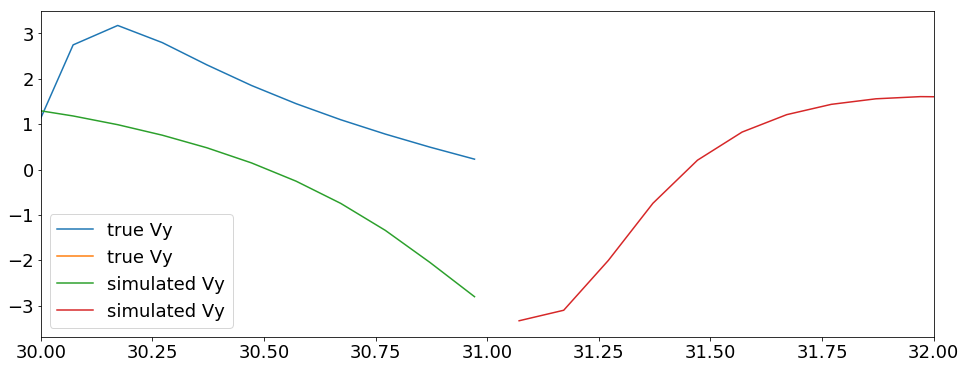

In [323]:
plt.figure(figsize=(16, 6))
plt.plot(sat['t'],sat['Vy'], label = 'true Vy');
plt.plot(sat['t'],sat['Vy_sim'], label = 'simulated Vy');

#plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([30,32])
plt.legend();
plt.savefig("35.png")

## Finding peaks and valleys (max/min)

Find zeros first, subdivide time by zeros of velocity, then max or min for each interval.

In [71]:
#Find zeros:
t = data['t']
x = data['Vx']
spl = InterpolatedUnivariateSpline(t, x)
spl.roots()

array([ 0.04993235,  0.5367329 ,  0.83759385,  1.32500676,  1.62602085,
        2.11325585,  2.4144107 ,  2.90147985,  3.20272896,  3.689679  ,
        3.99094656,  4.47785088,  4.77905078,  5.2659962 ,  5.56704375,
        6.05411324,  6.35494374,  6.84219946,  7.14278215,  7.63025133,
        7.93060383,  8.41826579,  8.71845366,  9.20623962,  9.50638048,
        9.99416953, 10.29443332, 10.78205353, 11.08265393, 11.56988842,
       11.87105366, 12.35767223, 12.65959719, 13.14540383, 13.44819628,
       13.93308451, 14.23673928, 14.7207117 , 15.02512225, 15.50828502,
       15.81328628, 16.29580423, 16.60121112, 17.08326901, 17.38890591,
       17.87067739, 18.17639221, 18.65803053, 18.96369758, 19.44532645,
       19.75085045, 20.23256344, 20.53787779, 21.01973874, 21.32480998,
       21.80685046, 22.11167698, 22.59389577, 22.89851129, 23.38086963,
       23.68534566, 24.16776858, 24.47221444, 24.95458745, 25.25915438,
       25.74132252, 26.04620442, 26.52797372, 26.83341544, 27.31

In [49]:
def best_stretch_coefficient(data, threshold = 0.05, iterations = 100,
                            true_feats = ['x','y','z','Vx','Vy','Vz']):
    '''
    find stretch coefficient that yields best smape for given satellite
    iterations: max number of iterations
    
    '''
    